# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir

from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
def explore_data(batch_id, sample_id):
    helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


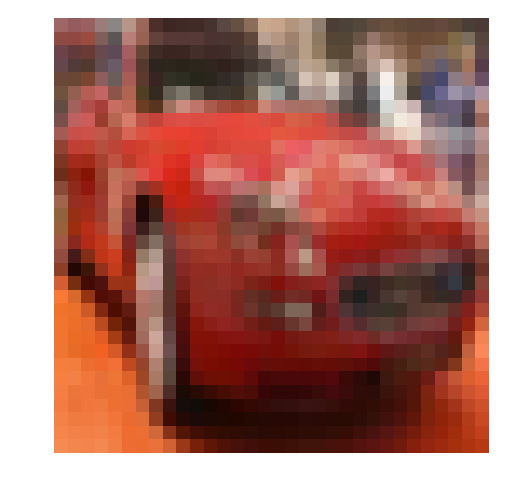

In [3]:
explore_data(1, 5)


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 10:
Image - Min Value: 4 Max Value: 231
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


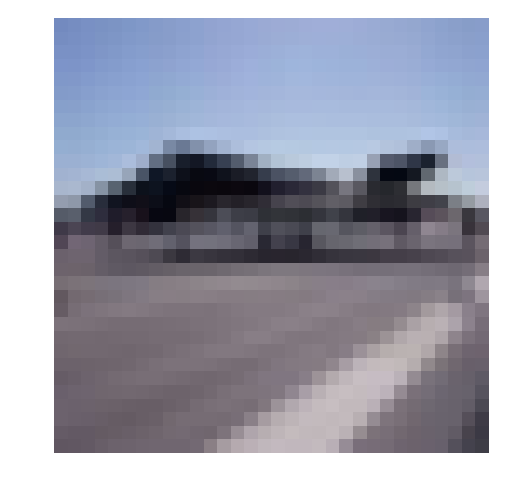

In [4]:
explore_data(2, 10)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 15:
Image - Min Value: 59 Max Value: 210
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


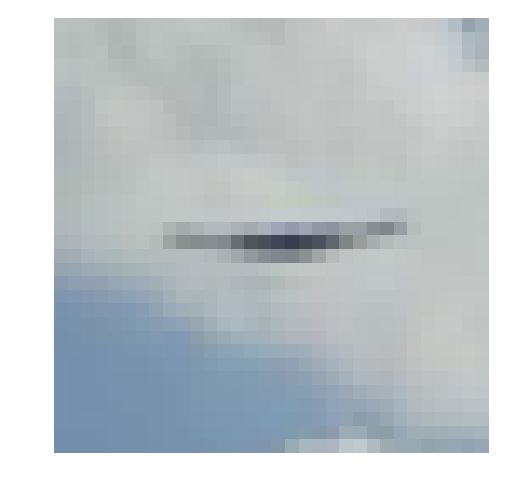

In [5]:
explore_data(3, 15)


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 20:
Image - Min Value: 18 Max Value: 223
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


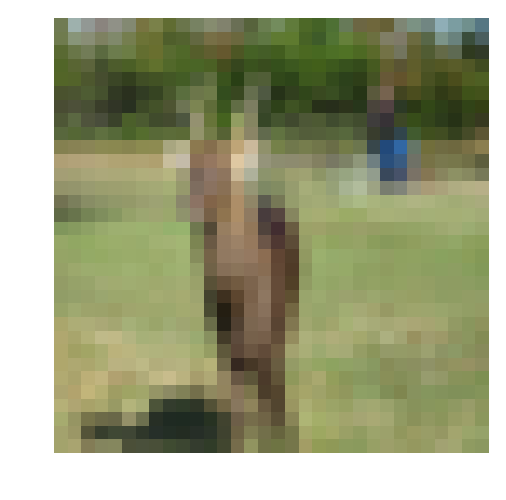

In [6]:
explore_data(4, 20)


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 25:
Image - Min Value: 0 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


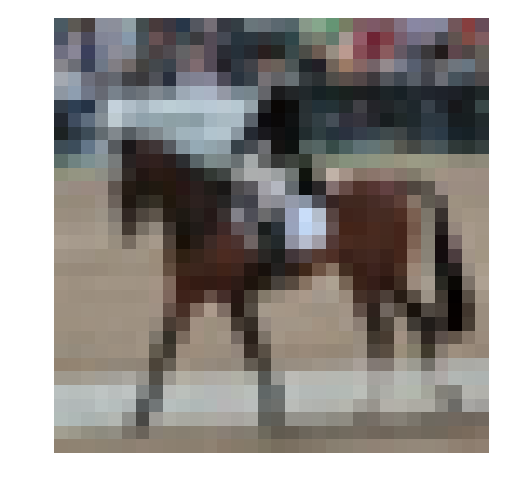

In [7]:
explore_data(5, 25)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [8]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    npx = np.array(x)
    x_normed = npx / npx.max(axis=0)
    return x_normed # return x/255

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [9]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    npx = np.array(x).reshape(-1, 1)
    enc = OneHotEncoder(n_values=10)
    enc.fit(npx)
    encodings = enc.transform(npx).toarray()
    return encodings # return np.eye(10)[x]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [12]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    output = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name="x")
    print_neural_net_image_input(image_shape, output)
    return output;
    

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    output = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name="y")
    print_neural_net_label_input(n_classes, output)
    return output


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    output = tf.placeholder(dtype=tf.float32, name="keep_prob")
    print_neural_net_keep_prob_input(output)
    return output


def print_neural_net_image_input(image_shape, output):
    print('')
    print('neural_net_image_input image_shape =', image_shape)
    print('neural_net_image_input output =', output)
    print('')

def print_neural_net_label_input(n_classes, output):
    print('')
    print('neural_net_label_input n_classes =', n_classes)
    print('neural_net_label_input output =', output)
    print('')    

def print_neural_net_keep_prob_input(output):
    print('')
    print('neural_net_keep_prob_input output =', output)
    print('')    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)


neural_net_image_input image_shape = (32, 32, 3)
neural_net_image_input output = Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)

Image Input Tests Passed.

neural_net_label_input n_classes = 10
neural_net_label_input output = Tensor("y:0", shape=(?, 10), dtype=float32)

Label Input Tests Passed.

neural_net_keep_prob_input output = Tensor("keep_prob:0", dtype=float32)

Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [13]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function

    input_depth = x_tensor.get_shape().as_list()[-1]
    
    filter_weight_shape = [conv_ksize[0], conv_ksize[1], input_depth, conv_num_outputs]
    conv_stride_shape = [1, conv_strides[0], conv_strides[1], 1]
    
    conv_filter_weights = tf.Variable(tf.truncated_normal(filter_weight_shape, mean=0.0, stddev=0.05))
    conv_filter_bias = tf.Variable(tf.zeros(conv_num_outputs))

    conv_layer_output = conv2d(x_tensor, conv_filter_weights, conv_filter_bias, conv_stride_shape)
    
    pool_ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    pool_stride_shape = [1, pool_strides[0], pool_strides[1], 1]

    max_pool_layer_output = maxpool2d(conv_layer_output, pool_ksize, pool_stride_shape)

    print_conv2d_maxpool_input_output(x_tensor, conv_layer_output, conv_layer_output, max_pool_layer_output)
    
    return max_pool_layer_output


def conv2d(x, conv_filter_weights, conv_filter_bias, conv_stride_shape):
    x = tf.nn.conv2d(x, conv_filter_weights, conv_stride_shape, padding='SAME')
    x = tf.nn.bias_add(x, conv_filter_bias)
    return tf.nn.relu(x)

def maxpool2d(x, pool_ksize, pool_stride_shape):
    return tf.nn.max_pool(x, ksize=pool_ksize, strides=pool_stride_shape, padding='SAME')


def print_conv2d_maxpool_input_output(conv_layer_input, conv_layer_output, pool_layer_input, pool_layer_output):
    print('')
    print_tensor('conv_layer_input', conv_layer_input)
    print_tensor('conv_layer_output', conv_layer_output)
    print_tensor('pool_layer_input', pool_layer_input)
    print_tensor('pool_layer_output', pool_layer_output)
    print('')
    print('')

def print_tensor(label, tensor):
    print("{} = {}".format(label, tensor))
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)


conv_layer_input = Tensor("Placeholder:0", shape=(?, 32, 32, 5), dtype=float32)
conv_layer_output = Tensor("Relu:0", shape=(?, 8, 8, 10), dtype=float32)
pool_layer_input = Tensor("Relu:0", shape=(?, 8, 8, 10), dtype=float32)
pool_layer_output = Tensor("MaxPool:0", shape=(?, 4, 4, 10), dtype=float32)


Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    output = tf.contrib.layers.flatten(x_tensor)
    print_flatten_input_output(x_tensor, output)
    return output


def print_flatten_input_output(flatten_input, flatten_output):
    print('')
    print_tensor('flatten_input', flatten_input)
    print_tensor('flatten_output', flatten_output)
    print('')
    print('')

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)


flatten_input = Tensor("Placeholder_1:0", shape=(?, 10, 30, 6), dtype=float32)
flatten_output = Tensor("Flatten/Reshape:0", shape=(?, 1800), dtype=float32)


Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [15]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    input_size, num_outputs = extract_fc_or_output_layer_dimensions(x_tensor, num_outputs)
    
    weights = tf.Variable(tf.truncated_normal([input_size, num_outputs], mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fc_layer = tf.reshape(x_tensor, [-1, weights.get_shape().as_list()[0]])
    fc_layer = tf.add(tf.matmul(fc_layer, weights), bias)
    
    fc_layer_output = tf.nn.relu(fc_layer)
    
    print_fully_conn_input_output(x_tensor, fc_layer_output)

    return fc_layer_output


def extract_fc_or_output_layer_dimensions(x_tensor, num_outputs):
    input_shape = x_tensor.get_shape()
    input_size = int(input_shape[1])
    return input_size, num_outputs


def print_fully_conn_input_output(fc_layer_input, fc_layer_output):
    print('')
    print_tensor('fc_layer_input', fc_layer_input)
    print_tensor('fc_layer_output', fc_layer_output)
    print('')
    print('')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)


fc_layer_input = Tensor("Placeholder_2:0", shape=(?, 128), dtype=float32)
fc_layer_output = Tensor("Relu_1:0", shape=(?, 40), dtype=float32)


Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    input_size, num_outputs = extract_fc_or_output_layer_dimensions(x_tensor, num_outputs)
    
    weights = tf.Variable(tf.truncated_normal([input_size, num_outputs], mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.zeros(num_outputs))

    out = tf.add(tf.matmul(x_tensor, weights), bias)

    print_output_layer_input_output(x_tensor, out)
    
    return out


def print_output_layer_input_output(output_layer_input, output_layer_output):
    print('')
    print_tensor('output_layer_input', output_layer_input)
    print_tensor('output_layer_output', output_layer_output)
    print('')
    print('')
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)


output_layer_input = Tensor("Placeholder_3:0", shape=(?, 128), dtype=float32)
output_layer_output = Tensor("Add_1:0", shape=(?, 40), dtype=float32)


Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('CONVOLUTIONAL LAYER 1')
    print('')
    
    conv_num_outputs = 32
    
    conv_ksize = [3,3]
    conv_strides = [1,1]
    pool_ksize = [2,2]
    pool_strides = [2,2]
    
    conv1 = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('CONVOLUTIONAL LAYER 2')
    print('')
    
    conv_num_outputs = 64
    
    conv2 = conv2d_maxpool(conv1, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('CONVOLUTIONAL LAYER 3')
    print('')
    
    conv_num_outputs = 128
    
    conv3 = conv2d_maxpool(conv2, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('FLATTEN LAYER')
    print('')
    
    flat = flatten(conv3)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('FULLY CONNECTED LAYER 1')
    print('')
    
    fc_num_outputs = 64
    
    fc1 = fully_conn(flat, fc_num_outputs)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('FULLY CONNECTED LAYER 2')
    print('')
    
    fc_num_outputs = 32
    
    fc2 = fully_conn(fc1, fc_num_outputs)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    print('')
    print('-----------------------------------------------------------------------------')
    print('OUTPUT LAYER')
    print('')
    
    out_num_outputs = 10
    
    out = output(fc2, out_num_outputs)
    
    print('-----------------------------------------------------------------------------')
    
    # TODO: return output
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)


neural_net_image_input image_shape = (32, 32, 3)
neural_net_image_input output = Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)


neural_net_label_input n_classes = 10
neural_net_label_input output = Tensor("y:0", shape=(?, 10), dtype=float32)


neural_net_keep_prob_input output = Tensor("keep_prob:0", dtype=float32)


-----------------------------------------------------------------------------
CONVOLUTIONAL LAYER 1


conv_layer_input = Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)
conv_layer_output = Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
pool_layer_input = Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
pool_layer_output = Tensor("MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)



-----------------------------------------------------------------------------
CONVOLUTIONAL LAYER 2


conv_layer_input = Tensor("MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
conv_layer_output = Tensor("Relu_1:0", shape=(?, 16, 16, 64), dtype=float32)
pool_layer_input

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [18]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function    
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    
    valid_acc = session.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [20]:
# TODO: Tune Parameters
epochs = 100
batch_size = 512
keep_probability = 0.75

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2324 Validation Accuracy: 0.153000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1696 Validation Accuracy: 0.235200
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.0396 Validation Accuracy: 0.267800
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.0071 Validation Accuracy: 0.267800
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.9469 Validation Accuracy: 0.310800
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.8542 Validation Accuracy: 0.338200
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.8286 Validation Accuracy: 0.340600
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.7928 Validation Accuracy: 0.347400
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.7406 Validation Accuracy: 0.370200
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.7203 Validation Accuracy: 0.372000
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.6980 Validation Accuracy: 0.380000
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.6305 Validation Accuracy: 0.408200
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.5831

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2580 Validation Accuracy: 0.110600
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.1315 Validation Accuracy: 0.200200
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.0035 Validation Accuracy: 0.263600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.9221 Validation Accuracy: 0.276600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.9158 Validation Accuracy: 0.296000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9253 Validation Accuracy: 0.303400
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.7993 Validation Accuracy: 0.345000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.6199 Validation Accuracy: 0.366800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.6148 Validation Accuracy: 0.368800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.6857 Validation Accuracy: 0.382400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7141 Validation Accuracy: 0.386400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6447 Validation Accuracy: 0.405000
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.4648 Validation Accuracy: 0.416200


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.6360 Validation Accuracy: 0.671600
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.6810 Validation Accuracy: 0.670000
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.7118 Validation Accuracy: 0.689800
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.6746 Validation Accuracy: 0.687600
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.6140 Validation Accuracy: 0.689200
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.6262 Validation Accuracy: 0.672800
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.6781 Validation Accuracy: 0.676200
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.6898 Validation Accuracy: 0.686200
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.6792 Validation Accuracy: 0.690000
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.5993 Validation Accuracy: 0.696400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.5749 Validation Accuracy: 0.681400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.6218 Validation Accuracy: 0.681800
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.6651 Validation Accuracy: 0.691200
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.3468 Validation Accuracy: 0.709600
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.3171 Validation Accuracy: 0.734000
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.2968 Validation Accuracy: 0.708600
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.3167 Validation Accuracy: 0.711400
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.3340 Validation Accuracy: 0.711400
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.3318 Validation Accuracy: 0.720400
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.3071 Validation Accuracy: 0.731200
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.2828 Validation Accuracy: 0.713600
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.3048 Validation Accuracy: 0.724400
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.3087 Validation Accuracy: 0.715200
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.3300 Validation Accuracy: 0.699600
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.2860 Validation Accuracy: 0.731000
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.2771 Validation Accuracy: 0.712800
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.1739 Validation Accuracy: 0.721400
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.1703 Validation Accuracy: 0.722400
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.1453 Validation Accuracy: 0.722000
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.1640 Validation Accuracy: 0.715800
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.1637 Validation Accuracy: 0.719800
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.1605 Validation Accuracy: 0.723200
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.1767 Validation Accuracy: 0.727600
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.1531 Validation Accuracy: 0.726200
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.1523 Validation Accuracy: 0.722000
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.1445 Validation Accuracy: 0.725800
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.1390 Validation Accuracy: 0.725400
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.1897 Validation Accuracy: 0.720400
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.1485 Validation Accuracy: 0.725200
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0761 Validation Accuracy: 0.719600
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0847 Validation Accuracy: 0.722800
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0811 Validation Accuracy: 0.713800
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0944 Validation Accuracy: 0.716400
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0912 Validation Accuracy: 0.720200
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0526 Validation Accuracy: 0.723600
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0915 Validation Accuracy: 0.710200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0900 Validation Accuracy: 0.716000
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0864 Validation Accuracy: 0.718800
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0679 Validation Accuracy: 0.719800
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0705 Validation Accuracy: 0.720200
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0806 Validation Accuracy: 0.715600
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0907 Validation Accuracy: 0.717600
Epoch 90, CI

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.710908779501915



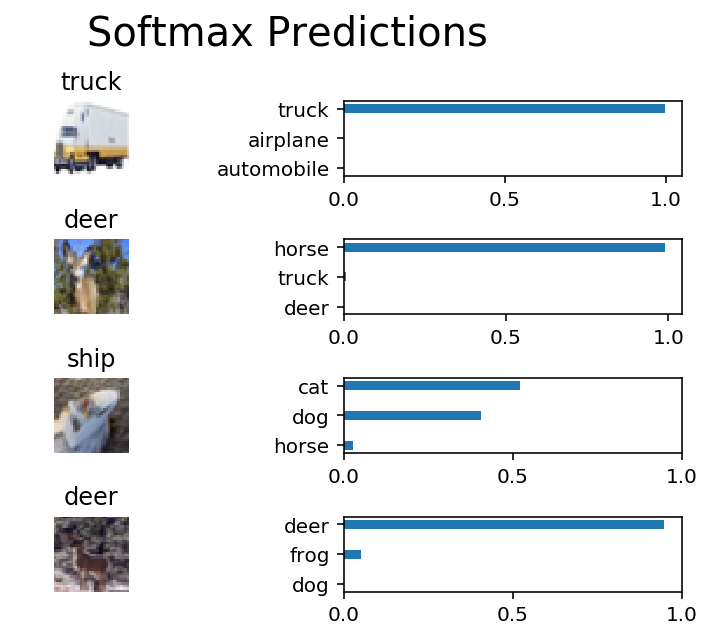

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.